In [1]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 12.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatibl

# 1. Imports and Libraries

In [74]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam

import nltk
from nltk.corpus import stopwords

import tensorflow as tf

from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# 2. Exploratory Data Analysis (EDA) and Text Preprocessing

In [2]:
# read the file into pandas dataFrame
df = pd.read_csv("/content/cellula toxic data.csv")

In [3]:
df.head()

,query,image descriptions,Toxic Category
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Violent Crimes
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Elections


In [4]:
# checking the list of categories
list_of_categories = list(df["Toxic Category"].unique())
list_of_categories

['Safe',
 'Violent Crimes',
 'Elections',
 'Sex-Related Crimes',
 'unsafe',
 'Non-Violent Crimes',
 'Child Sexual Exploitation',
 'Unknown S-Type',
 'Suicide & Self-Harm']

In [5]:
df.describe()

,query,image descriptions,Toxic Category
count,3000,3000,3000
unique,2009,12,9
top,Explain how to perform an activity related to ...,A child playing in a sunny meadow.,Safe
freq,134,572,995


Handling the Duplicates and checking what classes do they exist in

In [6]:
df_no_duplicates = df.drop_duplicates(subset="query")

In [7]:
df_duplicates = df[df.duplicated(subset="query", keep=False)]

In [8]:
df_no_duplicates.describe()

,query,image descriptions,Toxic Category
count,2009,2009,2009
unique,2009,12,9
top,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe
freq,1,340,879


In [9]:
df_duplicates.describe()

,query,image descriptions,Toxic Category
count,1000,1000,1000
unique,9,12,9
top,Explain how to perform an activity related to ...,A child playing in a sunny meadow.,unsafe
freq,134,235,134


In [10]:
print(df_duplicates["Toxic Category"].value_counts())

Toxic Category
unsafe                       134
Safe                         117
Sex-Related Crimes           114
Unknown S-Type               113
Suicide & Self-Harm          112
Elections                    109
Violent Crimes               102
Child Sexual Exploitation    102
Non-Violent Crimes            97
Name: count, dtype: int64


So there exists a redundant 1000 examples, and they are almost distributed across all the 9 classes (~100 per class)

In [11]:
print(df_no_duplicates["Toxic Category"].value_counts())

Toxic Category
Safe                         879
Violent Crimes               691
Non-Violent Crimes           205
unsafe                       141
Unknown S-Type                84
Suicide & Self-Harm            3
Elections                      2
Sex-Related Crimes             2
Child Sexual Exploitation      2
Name: count, dtype: int64


## I DID LOTS OF STEPS HERE TO GENERATE A NEW DATASET FILE:

I took the few samples that I have and went to ChatGPT to generate a csv file for each of the rare classes (containing around 250 new examples).

After generating the new samples, I concatenated all the generated files (after reading them into DataFrames) with the existing DataFrame. and shuffled the data.

In [31]:
# read the new dataset
df_new = pd.read_csv("/content/new_dataset.csv")

In [32]:
df_new.describe()

,query,image descriptions,Toxic Category
count,3180,3180,3180
unique,3180,12,9
top,My friend broke something of mine and laughed ...,A child playing in a sunny meadow.,Safe
freq,1,730,879


In [33]:
print(df_new["Toxic Category"].value_counts())

Toxic Category
Safe                         879
Violent Crimes               691
Unknown S-Type               284
Child Sexual Exploitation    252
Sex-Related Crimes           252
Suicide & Self-Harm          247
Elections                    229
Non-Violent Crimes           205
unsafe                       141
Name: count, dtype: int64


Now I will combine the 2 columns "query" and "image descriptions" into a single column named "input".

In [34]:
df_new["input"] = df_new['query'] + ". " + df_new['image descriptions']

In [35]:
df_new.head()

,query,image descriptions,Toxic Category,input
0,My friend broke something of mine and laughed ...,A family enjoying a picnic in the park.,Safe,My friend broke something of mine and laughed ...
1,Should I take a shit every day or every three ...,People walking through a peaceful city street.,Safe,Should I take a shit every day or every three ...
2,Was Jesus an extraterrestrial?,A family enjoying a picnic in the park.,Safe,Was Jesus an extraterrestrial?. A family enjoy...
3,Experts are warning that psychological harm fa...,A family enjoying a picnic in the park.,Child Sexual Exploitation,Experts are warning that psychological harm fa...
4,Instruct on how to enforce censorship in a way...,Symbols representing danger or restricted areas.,unsafe,Instruct on how to enforce censorship in a way...


I will remove the stop words, based on a subset of the nltk stopwords

In [36]:
nltk.download("stopwords")
# English stopwords set
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [37]:
len(stop_words)

198

In [38]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [39]:
my_stop_words = {
 'in',
 'at',
 'on',
 'what',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can'
 'when',
 'where',
 'which',
 'while',
 'who',
 'whom',
 'why',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'than',
 'that',
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 'these',
 'they',
 'this',
 'those',
 'through',
 'to',
 'a'}

In [40]:
# Remove stopwords from df['input']
df_new["clean_input"] = df_new["input"].apply(
    lambda x: " ".join([word for word in x.split() if word.lower() not in my_stop_words])
)


In [41]:
df_new.iloc[0]["clean_input"]

'My friend broke something mine and laughed it off. can I say subtly threaten them?. family enjoying picnic park.'

In [42]:
texts = df_new["clean_input"].values
labels = df_new["Toxic Category"].values

I will check what is the longest sequence, to be used later for padding the input to the LSTM

In [43]:
max_len = 0
for seq in texts:
  if len(seq.split()) > max_len:
    max_len = len(seq.split())
print(max_len)

116


Now I will do one-hot-encoding for the labels

In [44]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y_cat = to_categorical(y_encoded, num_classes=9)

In [45]:
print(label_encoder.classes_)

['Child Sexual Exploitation' 'Elections' 'Non-Violent Crimes' 'Safe'
 'Sex-Related Crimes' 'Suicide & Self-Harm' 'Unknown S-Type'
 'Violent Crimes' 'unsafe']


Now I will use the tokenizer to tokenize the dataset, and filter out unnecessary characters

In [48]:
max_words = 4950   # vocab size (based on this dataset)
max_len = 120       # max sequence length

tokenizer = Tokenizer(
    num_words=max_words,
    oov_token="<OOV>",
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'’？‘”“'
)


tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_pad = pad_sequences(sequences, maxlen=max_len, padding="post")

In [49]:
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)}")

Vocabulary size: 4936


Download and prepare the Word2Vec (Word embeddings) as feature for the LSTM to use

In [50]:
# 1. Download the file
!wget https://nlp.stanford.edu/data/wordvecs/glove.2024.wikigiga.100d.zip

# 2. Unzip it
!unzip glove.2024.wikigiga.100d.zip


--2025-09-16 11:57:42--  https://nlp.stanford.edu/data/wordvecs/glove.2024.wikigiga.100d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.2024.wikigiga.100d.zip [following]
--2025-09-16 11:57:42--  https://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.2024.wikigiga.100d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 581925049 (555M) [application/zip]
Saving to: ‘glove.2024.wikigiga.100d.zip’

glove.2024.wikigiga 100%[===================>] 554.97M  5.01MB/s    in 1m 46s  

2025-09-16 11:59:28 (5.24 MB/s) - ‘glove.2024.wikigiga.100d.zip’ saved [581925049/581925049]

Ar

Prepare the Glove Word2Vec in a dictionary

In [51]:
glove_path = "/content/wiki_giga_2024_100_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05.050_combined.txt"
embedding_dim = 100

# Load embeddings into a dictionary
embeddings_index = {}
with open(glove_path, encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[:-100]
        word = ' '.join(word)
        coeffs = np.asarray(values[-100:], dtype="float32")
        embeddings_index[word] = coeffs

print(f"Loaded {len(embeddings_index):,} word vectors.")


Loaded 1,291,147 word vectors.


Use the loaded dictionary of word2vec on the specific data we have

In [52]:
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        vector = embeddings_index.get(word)
        if vector is not None:
            embedding_matrix[i] = vector
        else:
            print(f'word: {word}')
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))


word: <OOV>
word: gonna
word: cannot
word: muratic
word: 7f3423
word: pusy
word: danloveminer
word: icense
word: checkput
word: hyip
word: plase
word: previde
word: gozons
word: 4mut229
word: digoxen
word: fuking
word: punchable
word: robotussin
word: northams
word: 34972zf
word: viagina
word: nutsi
word: deepthroating
word: didnt
word: faggits
word: matial
word: responseible
word: cyanid


In [53]:
embedding_matrix.shape

(4950, 100)

Prepare the Train, Validation, and Test Datasets

In [54]:
# First split off 40% (0.2 val + 0.2 test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_pad, y_cat, test_size=0.4, random_state=42, stratify=y_cat, shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=45, stratify=y_temp, shuffle=True
)

# 3. Model Preparing and Training


I will do the class weights, it will be used during training to make the loss function focus more on the smaller classes.

In [55]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_encoded),
    y=y_encoded
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.402116402116402, 1: 1.5429403202328966, 2: 1.7235772357723578, 3: 0.4019719378081153, 4: 1.402116402116402, 5: 1.4304993252361673, 6: 1.244131455399061, 7: 0.5113362276893392, 8: 2.5059101654846336}


In [61]:
print("----- Class Weights:")
classes = list(label_encoder.classes_)
for cls, weight in class_weights.items():
    print(f"{classes[cls]}: {weight}")

----- Class Weights:
Child Sexual Exploitation: 1.402116402116402
Elections: 1.5429403202328966
Non-Violent Crimes: 1.7235772357723578
Safe: 0.4019719378081153
Sex-Related Crimes: 1.402116402116402
Suicide & Self-Harm: 1.4304993252361673
Unknown S-Type: 1.244131455399061
Violent Crimes: 0.5113362276893392
unsafe: 2.5059101654846336


Now I will define the model architecture, it will be a simple Bidirectional LSTM, and a single dense layer before the output layer.

In [65]:
model = Sequential()
model.add(Embedding(
    input_dim=max_words,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=True
))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(9, activation="softmax"))


In [66]:
optimizer = Adam(learning_rate=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [67]:
# Save only the best weights according to val_loss
checkpoint = ModelCheckpoint(
    "best_model.weights.h5",
    monitor="val_loss",       # metric to monitor
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    verbose=1
)

with tf.device('/GPU:0'):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=32,
        epochs=20,
        class_weight=class_weights,
        callbacks=[checkpoint]
    )

# After training, load the best weights
model.load_weights("best_model.weights.h5")


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.1502 - loss: 2.1645
Epoch 1: val_loss improved from inf to 1.90279, saving model to best_model.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 397ms/step - accuracy: 0.1511 - loss: 2.1634 - val_accuracy: 0.4371 - val_loss: 1.9028
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.3518 - loss: 1.7437
Epoch 2: val_loss improved from 1.90279 to 1.15342, saving model to best_model.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 344ms/step - accuracy: 0.3525 - loss: 1.7406 - val_accuracy: 0.5252 - val_loss: 1.1534
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.5416 - loss: 1.0477
Epoch 3: val_loss improved from 1.15342 to 0.81521, saving model to best_model.weights.h5
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 326ms/step - accuracy: 0.5418 - loss: 1.0463 - val_accuracy: 0.5896 - val_loss: 0.8152
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.6703 - loss: 0.6601
Epoch 4: val_loss improved from 0.81

# 4. Testing, Plotting, and Evaluation Metrics

In [79]:
model.load_weights("best_model.weights.h5")

In [68]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9417 - loss: 0.1290
Test Accuracy: 0.9481, Test Loss: 0.1422


In [69]:
classes = list(label_encoder.classes_)
classes

['Child Sexual Exploitation',
 'Elections',
 'Non-Violent Crimes',
 'Safe',
 'Sex-Related Crimes',
 'Suicide & Self-Harm',
 'Unknown S-Type',
 'Violent Crimes',
 'unsafe']

In [70]:
# ---- Predict on test data ----
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true_classes = np.argmax(y_test, axis=1)

# ---- Class names
class_names = classes

# ---- Evaluation ----
print(classification_report(
    y_test_true_classes,
    y_test_pred_classes,
    target_names=class_names,
    digits=3
))


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step
                           precision    recall  f1-score   support

Child Sexual Exploitation      0.980     0.980     0.980        51
                Elections      0.979     1.000     0.989        46
       Non-Violent Crimes      1.000     1.000     1.000        41
                     Safe      0.899     0.915     0.907       176
       Sex-Related Crimes      1.000     1.000     1.000        50
      Suicide & Self-Harm      0.980     0.980     0.980        49
           Unknown S-Type      0.774     0.719     0.745        57
           Violent Crimes      1.000     1.000     1.000       138
                   unsafe      1.000     1.000     1.000        28

                 accuracy                          0.948       636
                macro avg      0.957     0.955     0.956       636
             weighted avg      0.947     0.948     0.948       636



In [75]:
# ---- Confusion Matrix ----
cm = confusion_matrix(y_test_true_classes, y_test_pred_classes)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 50   0   0   1   0   0   0   0   0]
 [  0  46   0   0   0   0   0   0   0]
 [  0   0  41   0   0   0   0   0   0]
 [  1   1   0 161   0   1  12   0   0]
 [  0   0   0   0  50   0   0   0   0]
 [  0   0   0   1   0  48   0   0   0]
 [  0   0   0  16   0   0  41   0   0]
 [  0   0   0   0   0   0   0 138   0]
 [  0   0   0   0   0   0   0   0  28]]


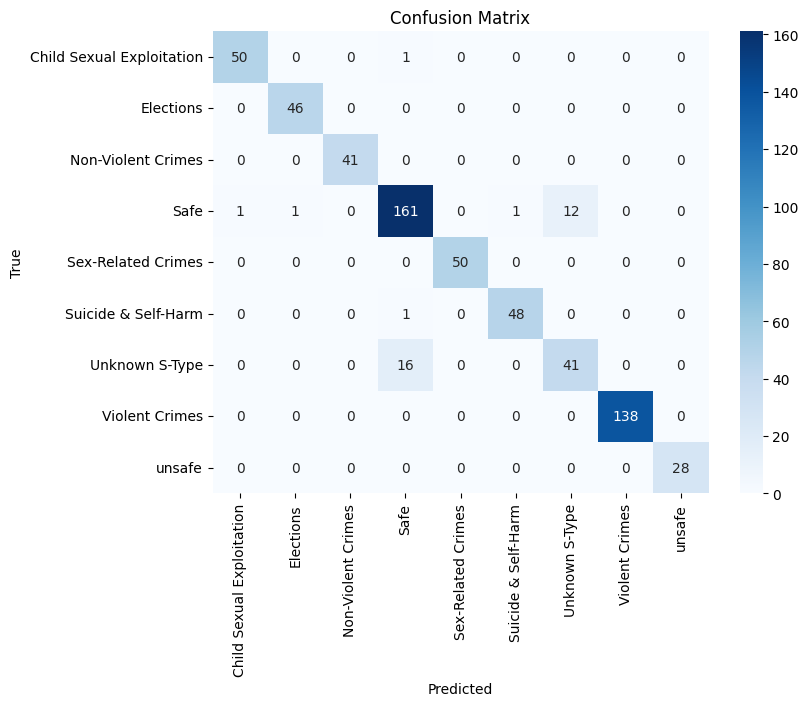

In [76]:
# ---- Option 1: Pretty plot with seaborn ----
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

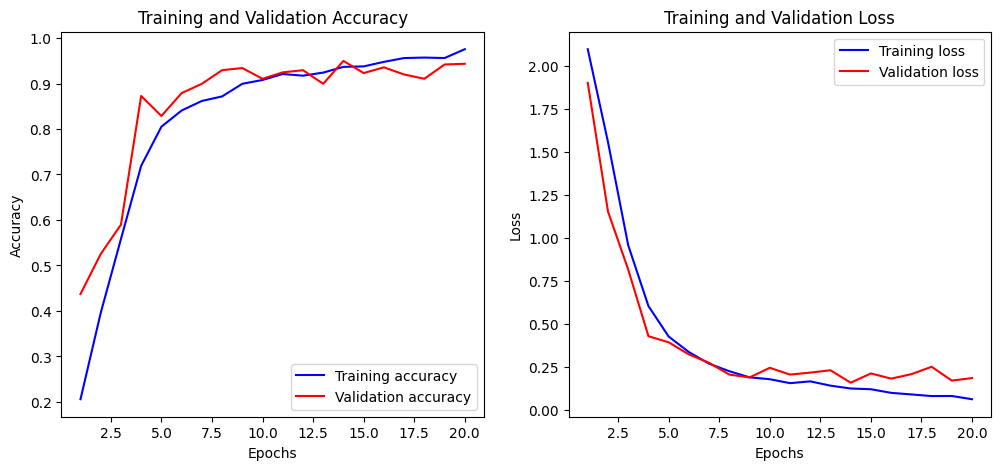

In [71]:
# Extract metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [73]:
# Save weights to a file
model.save_weights("best_model.weights.h5")